# Neural Style Transfer
STEPS:

**For each epoch:**
1. Compute features using pre-trained models like VGG, ResNet.
2. Compute content loss and style loss
3. Compute total combine loss.
4. Backpropagate Gradient to update generated image weights pixels.

In [64]:
# required imports
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
device

device(type='cuda')

### Preprocess and compute gram matrix function

In [66]:
def get_image(path, img_tranform, size=(300, 300)):
    "Read, Resize image and transform"
    image = Image.open(path)
    image = image.resize(size, Image.LANCZOS)
    image = img_transform(image).unsqueeze(0)
    return image.to(device)

def get_gram(m):
    """
    m is of shape(1, C, H, W) # batch size is always 1 in this case
    Compute gram matrix and return
    """
    # get the size
    _, c, h, w = m.size()
    # reshape in (C, -1)
    m = m.view(c, h * w)
    # matrix multiply
    m = torch.mm(m, m.t()) # m = MatrixMultiply(m, m.T)
    return m

# used for visualization
def denormalize_img(inp):
    # convert into numpy array with .numpy()
    inp = inp.numpy().transpose((1, 2, 0)) # C,H,W --> (H, W, C)
    mean = np.array([0.485, 0.456, 0.406]) # mean for R, G, B channels
    std = np.array([0.229, 0.224, 0.225])  # std for R, G, B channels
    inp = std * inp + mean  # In normalization (inp - mean) / std
    inp = np.clip(inp, 0, 1)
    return inp



### Compute features

In [67]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        # selected layers to extract features
        self.selected_layers = [3, 8, 15, 22]
        # here vgg16 is used, you can use any pretrained models like vgg19, Resnets
        # take vgg16 pretrained model and extract features
        self.vgg = models.vgg16(pretrained=True).features
    
    def forward(self, x):
        layer_features = []
        for layer_num, layer in self.vgg._modules.items():
            x = layer(x)
            if int(layer_num) in self.selected_layers:
                layer_features.append(x)
        return layer_features

### Prepare content and style image and freeze pre-trained model weights

In [68]:
img_transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(mean= (0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
content_img = get_image('content_zebra.jpg', img_transform, size=(300, 300))
style_img = get_image('pattern-2.jpg', img_transform)
# initial generated_img is copy of content_img
# at first content loss is 0 since it match
generated_img = content_img.clone()#or nn.Parameter(torch.FloatTensor(content_img.size()))
# enable backpropagation i.e weights updated
generated_img.requires_grad = True

optimizer = torch.optim.Adam([generated_img], lr=0.003, betas=[0.5, 0.999])
encoder = FeatureExtractor().to(device)

# frozen the weights of pretrained model
for p in encoder.parameters():
    p.requires_grad = False 

# encoder.eval() # frozen the weights


### Training
![]()

In [69]:
# default weightage
content_weight = 1 # alpha
style_weight = 100 # beta

for epoch in range(10000):
    # all three content, style and generated images
    # pass to the encoder to get features of each
    # encoder is a pre-trained vgg16 model
    content_features = encoder(content_img)
    style_features = encoder(style_img)
    generated_features = encoder(generated_img)
    
    # taking the last feature of content_
    # take the mse on that
    content_loss = torch.mean((content_features[-1] - generated_features[-1]) ** 2)
    
    # for each layer compute style loss
    # since style transformation should take care some minimal features on other layers too.
    # mse of gram_generated and gram_style features
    style_loss = 0
    for gf, sf in zip(generated_features, style_features):
        _, c, h, w = gf.size()
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)
        # mse loss and normalize w.r.to c,h and w
        style_loss += torch.mean((gram_gf - gram_sf)**2) / (c * h * w)
        
    # final total loss with its weightage
    loss = content_weight * content_loss + style_weight * style_loss
    # zeroth the gradients
    optimizer.zero_grad()
    # backpropagate
    loss.backward()
    # update the weights
    optimizer.step()
    
    if epoch % 10 == 0:
        print("Epoch [{}]]t Content Loss: {:.4f}\t Style Loss: {:.4f} ".format(epoch, content_loss.item(), style_loss.item()))

Epoch [0]]t Content Loss: 0.0000	 Style Loss: 4035.6697 
Epoch [10]]t Content Loss: 0.6289	 Style Loss: 3689.9119 
Epoch [20]]t Content Loss: 1.2889	 Style Loss: 3287.1233 
Epoch [30]]t Content Loss: 1.5479	 Style Loss: 2898.8979 
Epoch [40]]t Content Loss: 1.7279	 Style Loss: 2577.1047 
Epoch [50]]t Content Loss: 1.8863	 Style Loss: 2320.5247 
Epoch [60]]t Content Loss: 2.0172	 Style Loss: 2115.2017 
Epoch [70]]t Content Loss: 2.1347	 Style Loss: 1948.2805 
Epoch [80]]t Content Loss: 2.2408	 Style Loss: 1809.8398 
Epoch [90]]t Content Loss: 2.3403	 Style Loss: 1692.3423 
Epoch [100]]t Content Loss: 2.4460	 Style Loss: 1591.0638 
Epoch [110]]t Content Loss: 2.5505	 Style Loss: 1502.7644 
Epoch [120]]t Content Loss: 2.6474	 Style Loss: 1424.8204 
Epoch [130]]t Content Loss: 2.7389	 Style Loss: 1355.3381 
Epoch [140]]t Content Loss: 2.8214	 Style Loss: 1293.0334 
Epoch [150]]t Content Loss: 2.9001	 Style Loss: 1236.8525 
Epoch [160]]t Content Loss: 2.9802	 Style Loss: 1185.6930 
Epoch [1

In [71]:
inp = generated_img.detach().cpu().squeeze()
inp.shape

torch.Size([3, 300, 300])

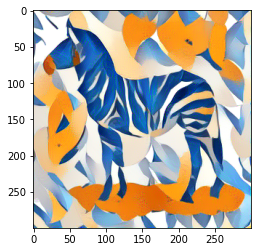

In [72]:
# denormalize image
inp = denormalize_img(inp)
plt.imshow(inp)

In [73]:
plt.imsave("generated_img.png",inp )